##### Importing Libraries



In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

init_notebook_mode(connected=True)
%matplotlib inline
# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings
warnings.filterwarnings("ignore")

In [9]:
# read the dataframe
df = pd.read_csv("all_stocks_5yr.csv")
df.head().style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border': '1.5px  white'})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


# Data cleaning



In [15]:
# rename Name to ticks
rdf = df.rename(columns={'Name':'ticks'})



In [16]:
rdf

date   open   high    low  close    volume ticks
0       2013-02-08  15.07  15.12  14.63  14.75   8407500   AAL
1       2013-02-11  14.89  15.01  14.26  14.46   8882000   AAL
2       2013-02-12  14.45  14.51  14.10  14.27   8126000   AAL
3       2013-02-13  14.30  14.94  14.25  14.66  10259500   AAL
4       2013-02-14  14.94  14.96  13.16  13.99  31879900   AAL
...            ...    ...    ...    ...    ...       ...   ...
619035  2018-02-01  76.84  78.27  76.69  77.82   2982259   ZTS
619036  2018-02-02  77.53  78.12  76.73  76.78   2595187   ZTS
619037  2018-02-05  76.64  76.92  73.18  73.83   2962031   ZTS
619038  2018-02-06  72.74  74.56  72.13  73.27   4924323   ZTS
619039  2018-02-07  72.70  75.00  72.69  73.86   4534912   ZTS

[619040 rows x 7 columns]

In [25]:
# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

In [26]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619029 non-null  object 
 1   open    619029 non-null  float64
 2   high    619029 non-null  float64
 3   low     619029 non-null  float64
 4   close   619029 non-null  float64
 5   volume  619029 non-null  int64  
 6   ticks   619029 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 37.8+ MB


In [28]:
# find the average volume of each stocks using function and sort top 10 most traded stocks for further analysis 
mean_dict = {}

# find average of volume traded over a period of time using for loops
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key ]['volume'].mean()
    mean_dict[key]= value

print("Length of the mean of ticks dictionary:", len(mean_dict))

# convert dict to pandas dataframe
avaerage_s = pd.Series(mean_dict).transpose()
top10_s = avaerage_s.sort_values(ascending=False)[:10]

print("Top 10 company tickers with highest average traded stock volume:\n", top10_s.index)

Length of the mean of ticks dictionary: 505
Top 10 company tickers with highest average traded stock volume:
 Index(['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO'], dtype='object')


In [31]:
# function to return top 10 sub dataframe
def subdataframe(df, tick):
    
    # top 10 ticks
    ticks = list(top10_s.index)
    
    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [32]:
# company dict for respective ticks (TOP 10 STOCKS BY AVERAGE TRAE VOLUME)
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'GE':'General Electric', 
                'F':'Ford Motor Company', 
                'FB':'Facebook', 
                'MSFT':'Microsoft', 
                'AMD':'Adavanced Micro Devices', 
                'MU':'Micron Technology', 
                'INTC':'Intel Corp', 
                'CSCO':'Cisco'
               }

bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')


# define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)

print('\t\tStart Date\t\t\t\t\tEnd Date')
print(f"BAC\t\t{bac_df['date'].min()}\t\t\t{bac_df['date'].max()}")
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"GE\t\t{ge_df['date'].min()}\t\t\t{ge_df['date'].max()}")
print(f"F\t\t{f_df['date'].min()}\t\t\t{f_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"MSFT\t\t{msft_df['date'].min()}\t\t\t{msft_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"MU\t\t{mu_df['date'].min()}\t\t\t{mu_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")
print(f"CSCO\t\t{csco_df['date'].min()}\t\t\t{csco_df['date'].max()}")

		Start Date					End Date
BAC		2013-02-08			2018-02-07
AAPL		2013-02-08			2018-02-07
GE		2013-02-08			2018-02-07
F		2013-02-08			2018-02-07
FB		2013-02-08			2018-02-07
MSFT		2013-02-08			2018-02-07
AMD		2013-02-08			2018-02-07
MU		2013-02-08			2018-02-07
INTC		2013-02-08			2018-02-07
CSCO		2013-02-08			2018-02-07


# stock price visualizations & maximum price during 5 years

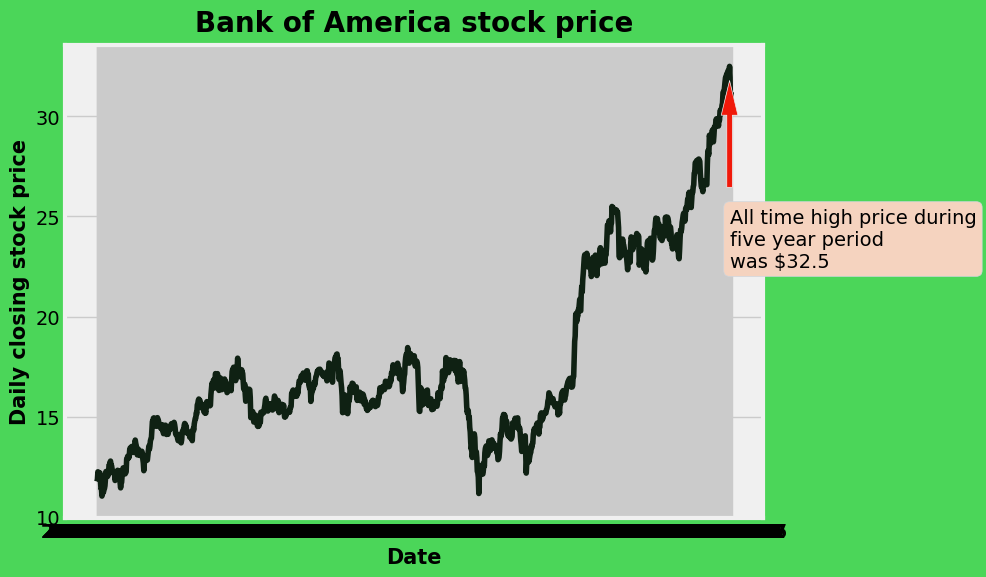

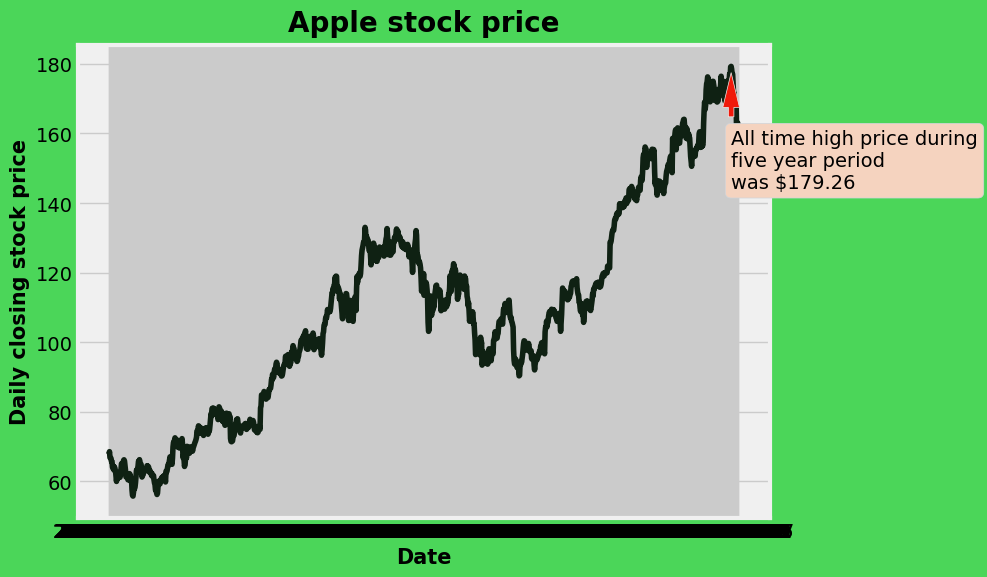

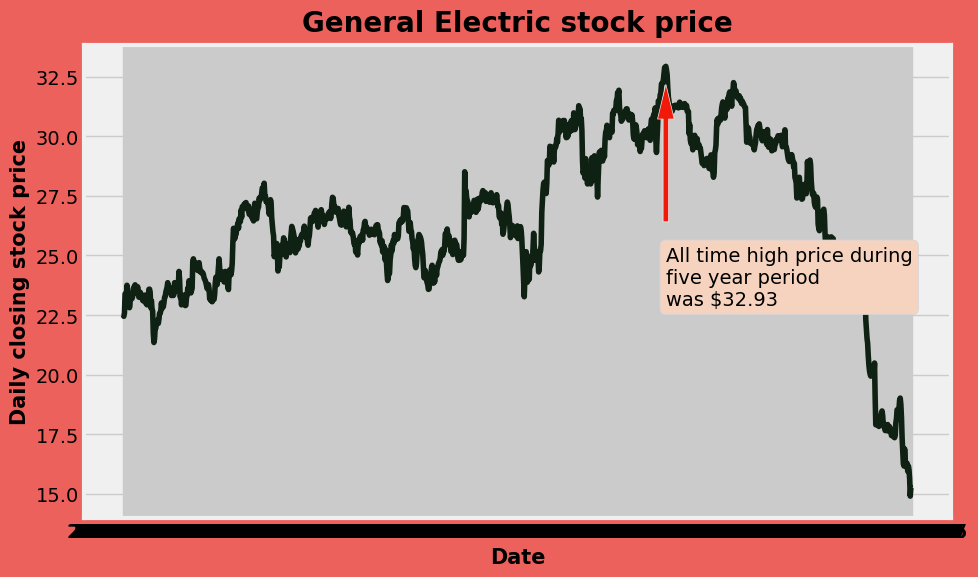

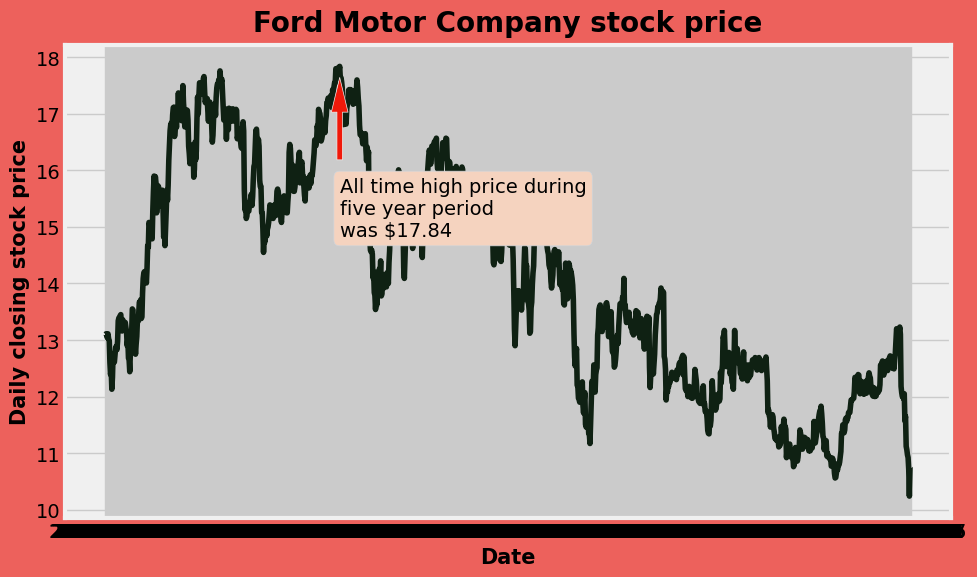

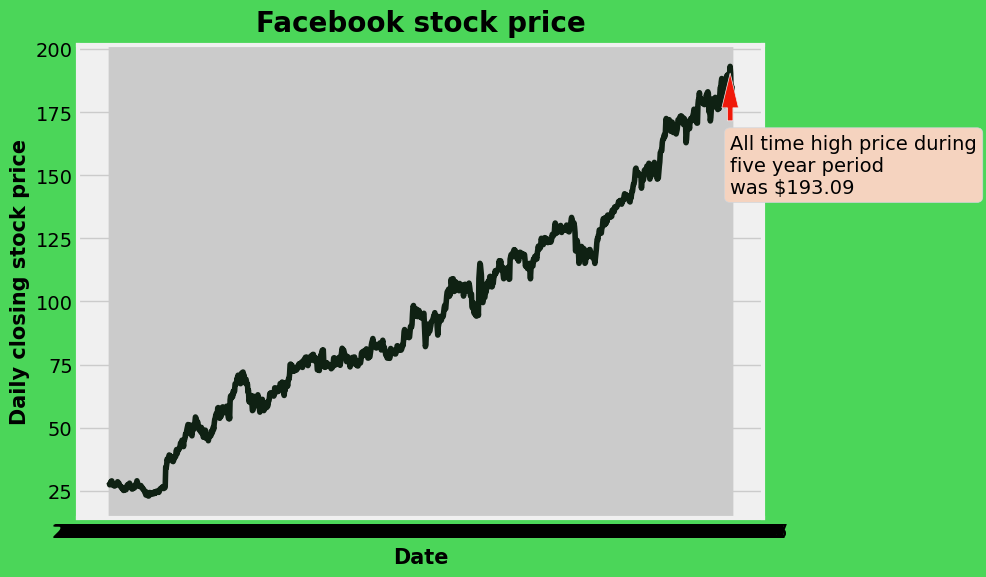

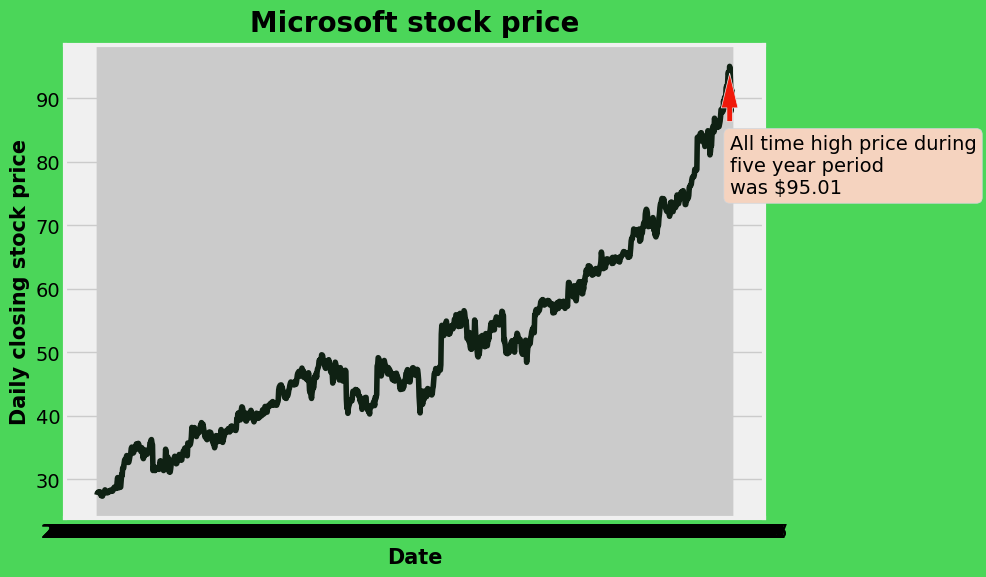

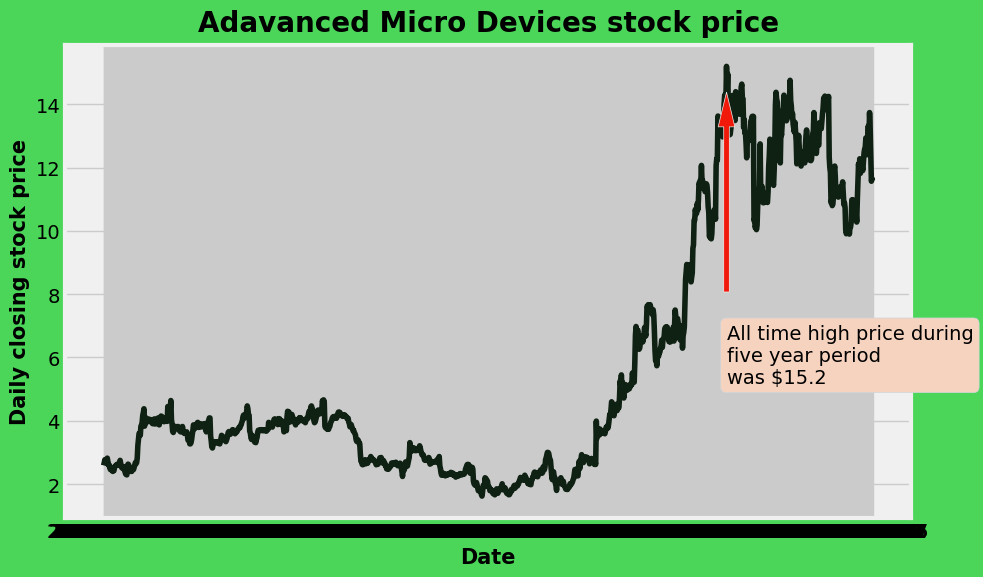

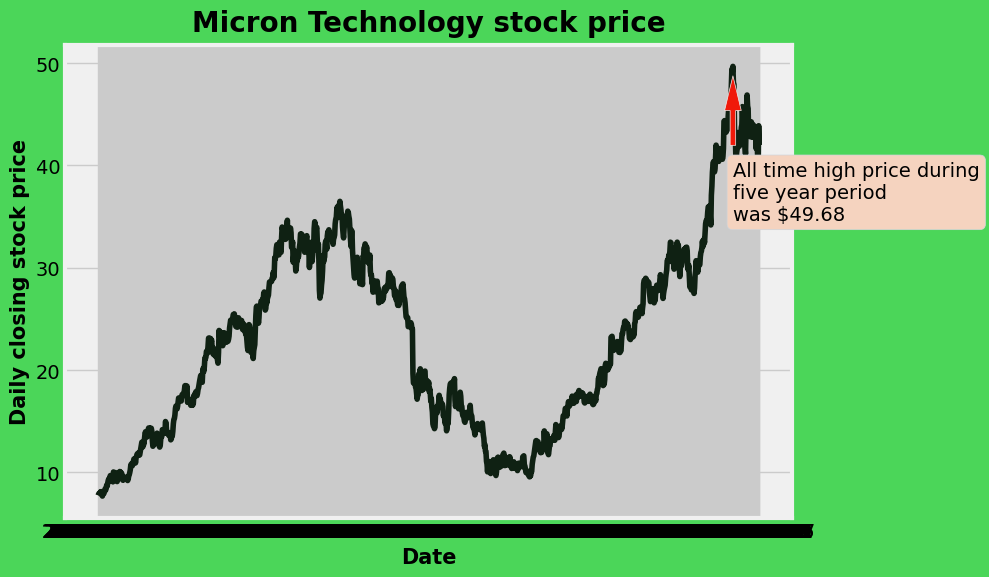

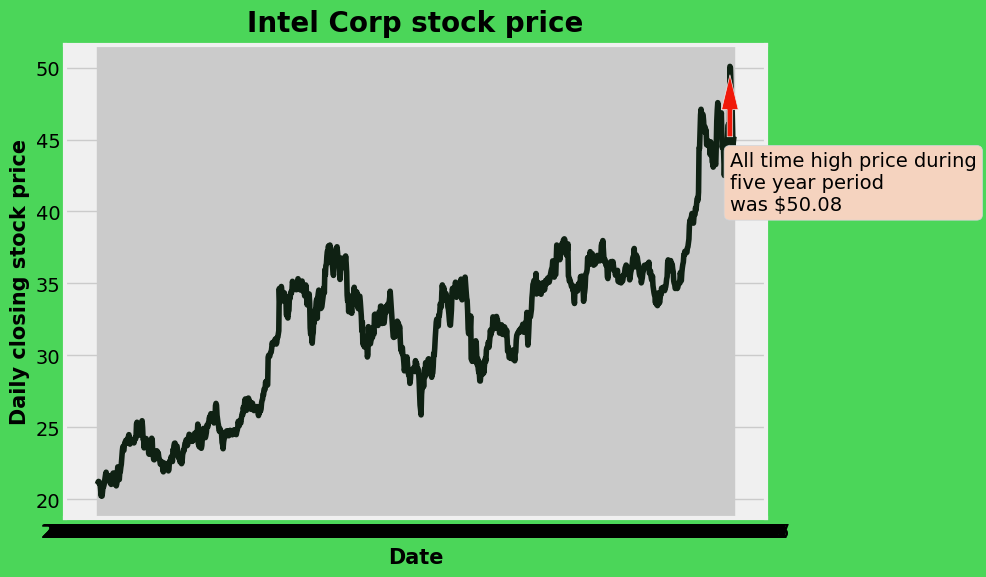

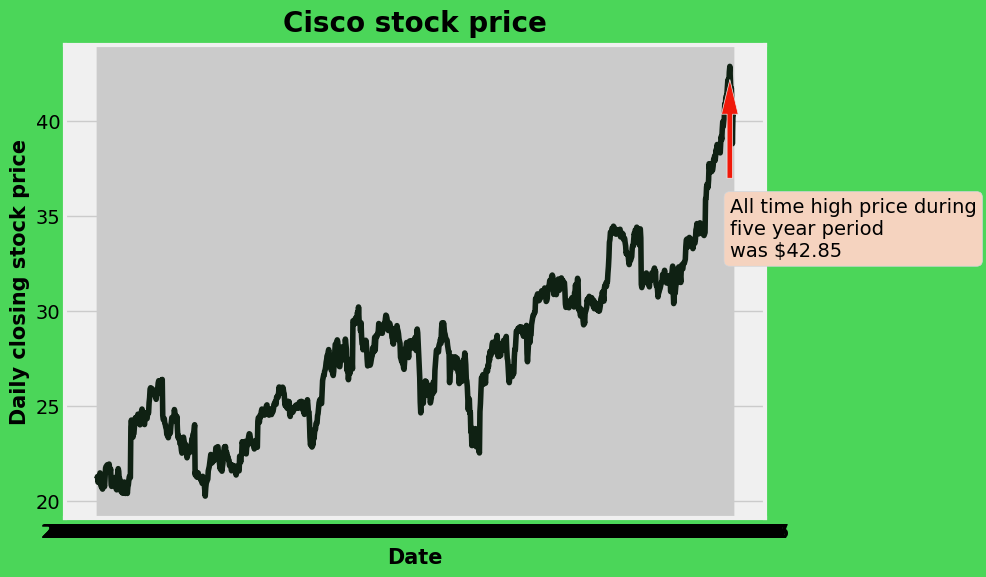

In [33]:
# function return closing stock price over a 5 years of time period
def closing_stock_price(df):
    
    # define highest stock over 5 period of time with date of the same
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    if df['ticks'].unique()[0] == 'GE':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    elif df['ticks'].unique()[0] == 'F':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    else:
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'F':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-3),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MSFT':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-20),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MU':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-15),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))

    plt.show()
    
# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)


# volume of stocks over a period of 2013-2018



In [44]:
# function to visualize trade volume of stocks
def trade_vol(df):
    
    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    # y coord for max trade vol
    max_y = df['volume'].max()
    # y coord for min trade vol
    min_y = df['volume'].min()
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}", 
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}", 
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}", 
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    
    plt.show()
    




In [45]:
# plot of all stocks trade volume
trade_vol(bac_df)
trade_vol(aapl_df)
trade_vol(ge_df)
trade_vol(f_df)
trade_vol(fb_df)
trade_vol(msft_df)
trade_vol(amd_df)
trade_vol(mu_df)
trade_vol(intc_df)
trade_vol(csco_df)

TypeError: Could not convert 2013-02-082013-02-112013-02-122013-02-132013-02-142013-02-152013-02-192013-02-202013-02-212013-02-222013-02-252013-02-262013-02-272013-02-282013-03-012013-03-042013-03-052013-03-062013-03-072013-03-082013-03-112013-03-122013-03-132013-03-142013-03-152013-03-182013-03-192013-03-202013-03-212013-03-222013-03-252013-03-262013-03-272013-03-282013-04-012013-04-022013-04-032013-04-042013-04-052013-04-082013-04-092013-04-102013-04-112013-04-122013-04-152013-04-162013-04-172013-04-182013-04-192013-04-222013-04-232013-04-242013-04-252013-04-262013-04-292013-04-302013-05-012013-05-022013-05-032013-05-062013-05-072013-05-082013-05-092013-05-102013-05-132013-05-142013-05-152013-05-162013-05-172013-05-202013-05-212013-05-222013-05-232013-05-242013-05-282013-05-292013-05-302013-05-312013-06-032013-06-042013-06-052013-06-062013-06-072013-06-102013-06-112013-06-122013-06-132013-06-142013-06-172013-06-182013-06-192013-06-202013-06-212013-06-242013-06-252013-06-262013-06-272013-06-282013-07-012013-07-022013-07-032013-07-052013-07-082013-07-092013-07-102013-07-112013-07-122013-07-152013-07-162013-07-172013-07-182013-07-192013-07-222013-07-232013-07-242013-07-252013-07-262013-07-292013-07-302013-07-312013-08-012013-08-022013-08-052013-08-062013-08-072013-08-082013-08-092013-08-122013-08-132013-08-142013-08-152013-08-162013-08-192013-08-202013-08-212013-08-222013-08-232013-08-262013-08-272013-08-282013-08-292013-08-302013-09-032013-09-042013-09-052013-09-062013-09-092013-09-102013-09-112013-09-122013-09-132013-09-162013-09-172013-09-182013-09-192013-09-202013-09-232013-09-242013-09-252013-09-262013-09-272013-09-302013-10-012013-10-022013-10-032013-10-042013-10-072013-10-082013-10-092013-10-102013-10-112013-10-142013-10-152013-10-162013-10-172013-10-182013-10-212013-10-222013-10-232013-10-242013-10-252013-10-282013-10-292013-10-302013-10-312013-11-012013-11-042013-11-052013-11-062013-11-072013-11-082013-11-112013-11-122013-11-132013-11-142013-11-152013-11-182013-11-192013-11-202013-11-212013-11-222013-11-252013-11-262013-11-272013-11-292013-12-022013-12-032013-12-042013-12-052013-12-062013-12-092013-12-102013-12-112013-12-122013-12-132013-12-162013-12-172013-12-182013-12-192013-12-202013-12-232013-12-242013-12-262013-12-272013-12-302013-12-312014-01-022014-01-032014-01-062014-01-072014-01-082014-01-092014-01-102014-01-132014-01-142014-01-152014-01-162014-01-172014-01-212014-01-222014-01-232014-01-242014-01-272014-01-282014-01-292014-01-302014-01-312014-02-032014-02-042014-02-052014-02-062014-02-072014-02-102014-02-112014-02-122014-02-132014-02-142014-02-182014-02-192014-02-202014-02-212014-02-242014-02-252014-02-262014-02-272014-02-282014-03-032014-03-042014-03-052014-03-062014-03-072014-03-102014-03-112014-03-122014-03-132014-03-142014-03-172014-03-182014-03-192014-03-202014-03-212014-03-242014-03-252014-03-262014-03-272014-03-282014-03-312014-04-012014-04-022014-04-032014-04-042014-04-072014-04-082014-04-092014-04-102014-04-112014-04-142014-04-152014-04-162014-04-172014-04-212014-04-222014-04-232014-04-242014-04-252014-04-282014-04-292014-04-302014-05-012014-05-022014-05-052014-05-062014-05-072014-05-082014-05-092014-05-122014-05-132014-05-142014-05-152014-05-162014-05-192014-05-202014-05-212014-05-222014-05-232014-05-272014-05-282014-05-292014-05-302014-06-022014-06-032014-06-042014-06-052014-06-062014-06-092014-06-102014-06-112014-06-122014-06-132014-06-162014-06-172014-06-182014-06-192014-06-202014-06-232014-06-242014-06-252014-06-262014-06-272014-06-302014-07-012014-07-022014-07-032014-07-072014-07-082014-07-092014-07-102014-07-112014-07-142014-07-152014-07-162014-07-172014-07-182014-07-212014-07-222014-07-232014-07-242014-07-252014-07-282014-07-292014-07-302014-07-312014-08-012014-08-042014-08-052014-08-062014-08-072014-08-082014-08-112014-08-122014-08-132014-08-142014-08-152014-08-182014-08-192014-08-202014-08-212014-08-222014-08-252014-08-262014-08-272014-08-282014-08-292014-09-022014-09-032014-09-042014-09-052014-09-082014-09-092014-09-102014-09-112014-09-122014-09-152014-09-162014-09-172014-09-182014-09-192014-09-222014-09-232014-09-242014-09-252014-09-262014-09-292014-09-302014-10-012014-10-022014-10-032014-10-062014-10-072014-10-082014-10-092014-10-102014-10-132014-10-142014-10-152014-10-162014-10-172014-10-202014-10-212014-10-222014-10-232014-10-242014-10-272014-10-282014-10-292014-10-302014-10-312014-11-032014-11-042014-11-052014-11-062014-11-072014-11-102014-11-112014-11-122014-11-132014-11-142014-11-172014-11-182014-11-192014-11-202014-11-212014-11-242014-11-252014-11-262014-11-282014-12-012014-12-022014-12-032014-12-042014-12-052014-12-082014-12-092014-12-102014-12-112014-12-122014-12-152014-12-162014-12-172014-12-182014-12-192014-12-222014-12-232014-12-242014-12-262014-12-292014-12-302014-12-312015-01-022015-01-052015-01-062015-01-072015-01-082015-01-092015-01-122015-01-132015-01-142015-01-152015-01-162015-01-202015-01-212015-01-222015-01-232015-01-262015-01-272015-01-282015-01-292015-01-302015-02-022015-02-032015-02-042015-02-052015-02-062015-02-092015-02-102015-02-112015-02-122015-02-132015-02-172015-02-182015-02-192015-02-202015-02-232015-02-242015-02-252015-02-262015-02-272015-03-022015-03-032015-03-042015-03-052015-03-062015-03-092015-03-102015-03-112015-03-122015-03-132015-03-162015-03-172015-03-182015-03-192015-03-202015-03-232015-03-242015-03-252015-03-262015-03-272015-03-302015-03-312015-04-012015-04-022015-04-062015-04-072015-04-082015-04-092015-04-102015-04-132015-04-142015-04-152015-04-162015-04-172015-04-202015-04-212015-04-222015-04-232015-04-242015-04-272015-04-282015-04-292015-04-302015-05-012015-05-042015-05-052015-05-062015-05-072015-05-082015-05-112015-05-122015-05-132015-05-142015-05-152015-05-182015-05-192015-05-202015-05-212015-05-222015-05-262015-05-272015-05-282015-05-292015-06-012015-06-022015-06-032015-06-042015-06-052015-06-082015-06-092015-06-102015-06-112015-06-122015-06-152015-06-162015-06-172015-06-182015-06-192015-06-222015-06-232015-06-242015-06-252015-06-262015-06-292015-06-302015-07-012015-07-022015-07-062015-07-072015-07-082015-07-092015-07-102015-07-132015-07-142015-07-152015-07-162015-07-172015-07-202015-07-212015-07-222015-07-232015-07-242015-07-272015-07-282015-07-292015-07-302015-07-312015-08-032015-08-042015-08-052015-08-062015-08-072015-08-102015-08-112015-08-122015-08-132015-08-142015-08-172015-08-182015-08-192015-08-202015-08-212015-08-242015-08-252015-08-262015-08-272015-08-282015-08-312015-09-012015-09-022015-09-032015-09-042015-09-082015-09-092015-09-102015-09-112015-09-142015-09-152015-09-162015-09-172015-09-182015-09-212015-09-222015-09-232015-09-242015-09-252015-09-282015-09-292015-09-302015-10-012015-10-022015-10-052015-10-062015-10-072015-10-082015-10-092015-10-122015-10-132015-10-142015-10-152015-10-162015-10-192015-10-202015-10-212015-10-222015-10-232015-10-262015-10-272015-10-282015-10-292015-10-302015-11-022015-11-032015-11-042015-11-052015-11-062015-11-092015-11-102015-11-112015-11-122015-11-132015-11-162015-11-172015-11-182015-11-192015-11-202015-11-232015-11-242015-11-252015-11-272015-11-302015-12-012015-12-022015-12-032015-12-042015-12-072015-12-082015-12-092015-12-102015-12-112015-12-142015-12-152015-12-162015-12-172015-12-182015-12-212015-12-222015-12-232015-12-242015-12-282015-12-292015-12-302015-12-312016-01-042016-01-052016-01-062016-01-072016-01-082016-01-112016-01-122016-01-132016-01-142016-01-152016-01-192016-01-202016-01-212016-01-222016-01-252016-01-262016-01-272016-01-282016-01-292016-02-012016-02-022016-02-032016-02-042016-02-052016-02-082016-02-092016-02-102016-02-112016-02-122016-02-162016-02-172016-02-182016-02-192016-02-222016-02-232016-02-242016-02-252016-02-262016-02-292016-03-012016-03-022016-03-032016-03-042016-03-072016-03-082016-03-092016-03-102016-03-112016-03-142016-03-152016-03-162016-03-172016-03-182016-03-212016-03-222016-03-232016-03-242016-03-282016-03-292016-03-302016-03-312016-04-012016-04-042016-04-052016-04-062016-04-072016-04-082016-04-112016-04-122016-04-132016-04-142016-04-152016-04-182016-04-192016-04-202016-04-212016-04-222016-04-252016-04-262016-04-272016-04-282016-04-292016-05-022016-05-032016-05-042016-05-052016-05-062016-05-092016-05-102016-05-112016-05-122016-05-132016-05-162016-05-172016-05-182016-05-192016-05-202016-05-232016-05-242016-05-252016-05-262016-05-272016-05-312016-06-012016-06-022016-06-032016-06-062016-06-072016-06-082016-06-092016-06-102016-06-132016-06-142016-06-152016-06-162016-06-172016-06-202016-06-212016-06-222016-06-232016-06-242016-06-272016-06-282016-06-292016-06-302016-07-012016-07-052016-07-062016-07-072016-07-082016-07-112016-07-122016-07-132016-07-142016-07-152016-07-182016-07-192016-07-202016-07-212016-07-222016-07-252016-07-262016-07-272016-07-282016-07-292016-08-012016-08-022016-08-032016-08-042016-08-052016-08-082016-08-092016-08-102016-08-112016-08-122016-08-152016-08-162016-08-172016-08-182016-08-192016-08-222016-08-232016-08-242016-08-252016-08-262016-08-292016-08-302016-08-312016-09-012016-09-022016-09-062016-09-072016-09-082016-09-092016-09-122016-09-132016-09-142016-09-152016-09-162016-09-192016-09-202016-09-212016-09-222016-09-232016-09-262016-09-272016-09-282016-09-292016-09-302016-10-032016-10-042016-10-052016-10-062016-10-072016-10-102016-10-112016-10-122016-10-132016-10-142016-10-172016-10-182016-10-192016-10-202016-10-212016-10-242016-10-252016-10-262016-10-272016-10-282016-10-312016-11-012016-11-022016-11-032016-11-042016-11-072016-11-082016-11-092016-11-102016-11-112016-11-142016-11-152016-11-162016-11-172016-11-182016-11-212016-11-222016-11-232016-11-252016-11-282016-11-292016-11-302016-12-012016-12-022016-12-052016-12-062016-12-072016-12-082016-12-092016-12-122016-12-132016-12-142016-12-152016-12-162016-12-192016-12-202016-12-212016-12-222016-12-232016-12-272016-12-282016-12-292016-12-302017-01-032017-01-042017-01-052017-01-062017-01-092017-01-102017-01-112017-01-122017-01-132017-01-172017-01-182017-01-192017-01-202017-01-232017-01-242017-01-252017-01-262017-01-272017-01-302017-01-312017-02-012017-02-022017-02-032017-02-062017-02-072017-02-082017-02-092017-02-102017-02-132017-02-142017-02-152017-02-162017-02-172017-02-212017-02-222017-02-232017-02-242017-02-272017-02-282017-03-012017-03-022017-03-032017-03-062017-03-072017-03-082017-03-092017-03-102017-03-132017-03-142017-03-152017-03-162017-03-172017-03-202017-03-212017-03-222017-03-232017-03-242017-03-272017-03-282017-03-292017-03-302017-03-312017-04-032017-04-042017-04-052017-04-062017-04-072017-04-102017-04-112017-04-122017-04-132017-04-172017-04-182017-04-192017-04-202017-04-212017-04-242017-04-252017-04-262017-04-272017-04-282017-05-012017-05-022017-05-032017-05-042017-05-052017-05-082017-05-092017-05-102017-05-112017-05-122017-05-152017-05-162017-05-172017-05-182017-05-192017-05-222017-05-232017-05-242017-05-252017-05-262017-05-302017-05-312017-06-012017-06-022017-06-052017-06-062017-06-072017-06-082017-06-092017-06-122017-06-132017-06-142017-06-152017-06-162017-06-192017-06-202017-06-212017-06-222017-06-232017-06-262017-06-272017-06-282017-06-292017-06-302017-07-032017-07-052017-07-062017-07-072017-07-102017-07-112017-07-122017-07-132017-07-142017-07-172017-07-182017-07-192017-07-202017-07-212017-07-242017-07-252017-07-262017-07-272017-07-282017-07-312017-08-012017-08-022017-08-032017-08-042017-08-072017-08-082017-08-092017-08-102017-08-112017-08-142017-08-152017-08-162017-08-172017-08-182017-08-212017-08-222017-08-232017-08-242017-08-252017-08-282017-08-292017-08-302017-08-312017-09-012017-09-052017-09-062017-09-072017-09-082017-09-112017-09-122017-09-132017-09-142017-09-152017-09-182017-09-192017-09-202017-09-212017-09-222017-09-252017-09-262017-09-272017-09-282017-09-292017-10-022017-10-032017-10-042017-10-052017-10-062017-10-092017-10-102017-10-112017-10-122017-10-132017-10-162017-10-172017-10-182017-10-192017-10-202017-10-232017-10-242017-10-252017-10-262017-10-272017-10-302017-10-312017-11-012017-11-022017-11-032017-11-062017-11-072017-11-082017-11-092017-11-102017-11-132017-11-142017-11-152017-11-162017-11-172017-11-202017-11-212017-11-222017-11-242017-11-272017-11-282017-11-292017-11-302017-12-012017-12-042017-12-052017-12-062017-12-072017-12-082017-12-112017-12-122017-12-132017-12-142017-12-152017-12-182017-12-192017-12-202017-12-212017-12-222017-12-262017-12-272017-12-282017-12-292018-01-022018-01-032018-01-042018-01-052018-01-082018-01-092018-01-102018-01-112018-01-122018-01-162018-01-172018-01-182018-01-192018-01-222018-01-232018-01-242018-01-252018-01-262018-01-292018-01-302018-01-312018-02-012018-02-022018-02-052018-02-062018-02-07 to numeric

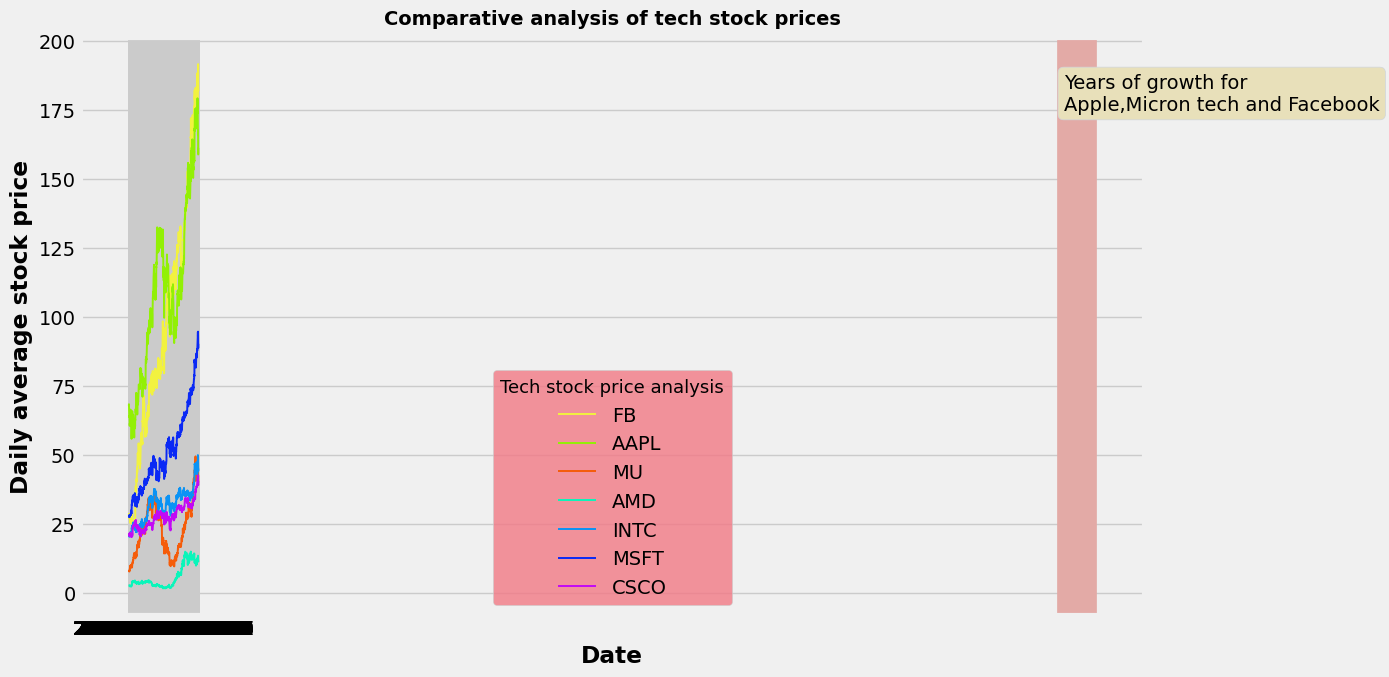

In [35]:
# tech stocks price comparison
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(fb_df['date'], fb_df['daily_mean'],label='FB', color='#f2f23f', lw=1.4)
ax.plot(aapl_df['date'], aapl_df['daily_mean'],label='AAPL', color='#92f005', lw=1.4)
ax.plot(mu_df['date'], mu_df['daily_mean'],label='MU', color='#f55c0a', lw=1.4)
ax.plot(amd_df['date'], amd_df['daily_mean'],label='AMD', color='#0af5ba', lw=1.4)
ax.plot(intc_df['date'], intc_df['daily_mean'],label='INTC', color='#0a93f5', lw=1.4)
ax.plot(msft_df['date'], msft_df['daily_mean'],label='MSFT', color='#0a29f5', lw=1.4)
ax.plot(csco_df['date'], csco_df['daily_mean'],label='CSCO', color='#c20af5', lw=1.4)
ax.axvspan(*mdates.datestr2num(['2/1/2016','12/31/2017']), color='#e3aaa6')
ax.set_title("Comparative analysis of tech stock prices")
ax.annotate("Years of growth for\nApple,Micron tech and Facebook", xy=(mdates.datestr2num('6/1/2016'),175),
           bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'))
ax.set_xlabel("Date")
ax.set_ylabel("Daily average stock price")
ax.legend(facecolor='#f27985', fontsize="medium", title="Tech stock price analysis", title_fontsize=13)

plt.show()

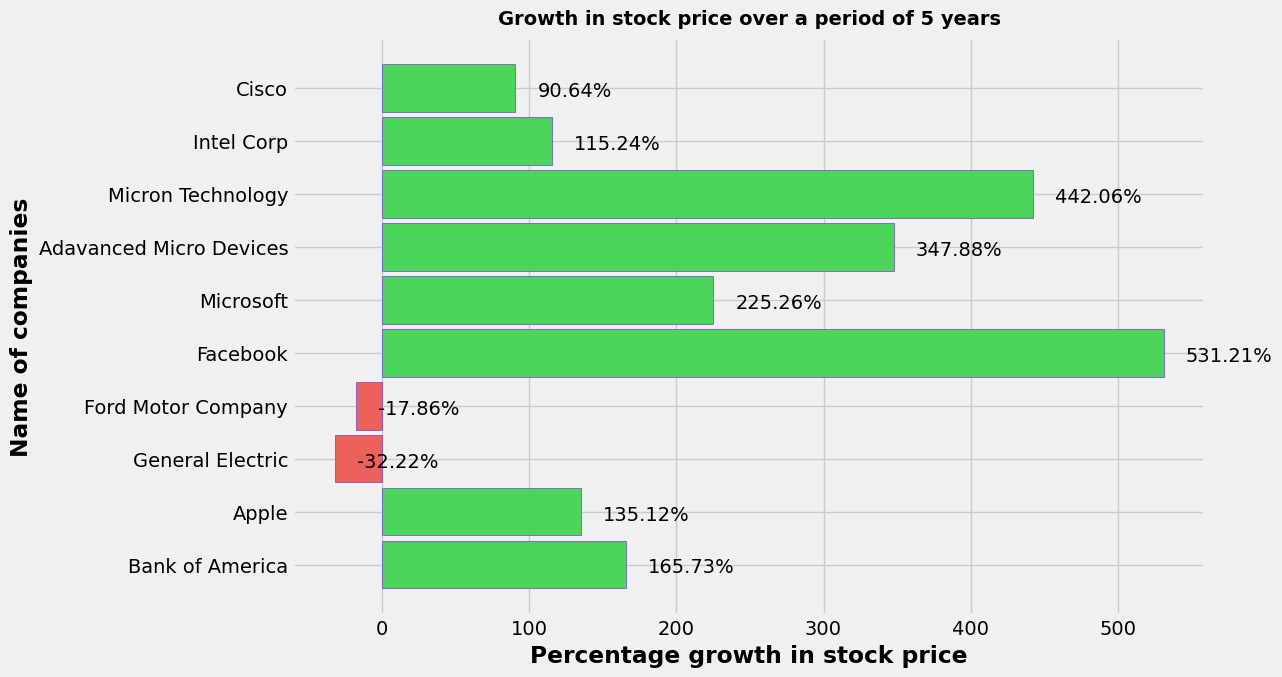

In [36]:
# list of stock dataframes
list_df = [bac_df, aapl_df, ge_df, f_df, fb_df, msft_df, amd_df, mu_df, intc_df, csco_df]

# loop through the the list_df to find mini and maxi of each stocks 
mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

# find list of abosolute difference between both stock price
diff = np.array(maxi) - np.array(mini)

# find the percentage growth
growth = (diff/mini)*100
growth_list = growth.tolist()
co_name_list = [df['co_name'].unique()[0] for df in list_df]

# visualize the growth of the stocks
fig, ax = plt.subplots(figsize=(13,7))
ax.barh(y=co_name_list, width=growth_list, height=0.9, color=['#4bd659','#4bd659','#ed615c','#ed615c','#4bd659',
                                                             '#4bd659','#4bd659','#4bd659','#4bd659','#4bd659'],
       edgecolor='#713ae8')
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y() +0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Name of companies')
ax.set_title("Growth in stock price over a period of 5 years")
plt.show()

In [37]:
result_dict = {}
for df in list_df:
    result = stats.ttest_1samp(df['daily return'], 0)
    result_dict[df['ticks'].unique()[0]] = result   
result_dict

{'BAC': TtestResult(statistic=-0.3532776176429947, pvalue=0.7239395130534507, df=1258),
 'AAPL': TtestResult(statistic=0.41429430560560776, pvalue=0.6787292124343913, df=1258),
 'GE': TtestResult(statistic=-0.6899014787481074, pvalue=0.4903833915917716, df=1258),
 'F': TtestResult(statistic=-1.829967497402379, pvalue=0.06749132535767648, df=1258),
 'FB': TtestResult(statistic=0.43179923117451596, pvalue=0.6659613318143065, df=1258),
 'MSFT': TtestResult(statistic=2.936864998172622, pvalue=0.00337582087561039, df=1258),
 'AMD': TtestResult(statistic=0.5320769266138293, pvalue=0.5947666691710993, df=1258),
 'MU': TtestResult(statistic=-0.3912233565721498, pvalue=0.6956983959552626, df=1258),
 'INTC': TtestResult(statistic=3.0472693720373076, pvalue=0.002357434011831407, df=1258),
 'CSCO': TtestResult(statistic=2.6892871186777536, pvalue=0.007255138945761972, df=1258)}

In [41]:

###### function to plot daily return and histogram of 10 stocks
def daily_return(df):
    
    # assign variables to annotation positions
    ave_x = df['date'].mean()
    y_max = df['daily return'].max()
    y_max_date = df[df['daily return'] == df['daily return'].max()]['date'].values
    dt = pd.to_datetime(y_max_date, '%Y%m%d%H%M%S')
    xb = dt.item().date()
    y_min = df['daily return'].min()
    y_mean = df['daily return'].mean()
    
    plt.figure(figsize=(13,6), facecolor='#4bd659')
    
    plt.subplot(121)
    plt.plot(df['date'], df['daily return'], color='#062e63')
    plt.axhline(y=df['daily return'].max(), color='green', ls='--')
    plt.axhline(y=df['daily return'].min(), color='red', ls='--')
    plt.xlabel('Date')
    plt.ylabel("Percentage return")
    plt.annotate(f"Min. daily return={round(df['daily return'].min(),2)}%", 
                xy=(ave_x,y_min),xytext=(ave_x,y_min),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    plt.annotate(f"Max. daily return={round(df['daily return'].max(),2)}%\nDate was={xb}", 
                xy=(ave_x,y_max),xytext=(ave_x,y_max-0.6),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db', alpha=0.7)
                 )
    plt.title(f"Daily return of stock {df['co_name'].unique()[0]}")
    
    plt.subplot(122)
    plt.hist(df['daily return'], density=True, color='#0f52a8')
    plt.xlabel('Histogram')
    plt.axvline(x=df['daily return'].mean(), color='yellow', ls='--')
    if df['ticks'].unique()[0] == 'AMD':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.10),xytext=(y_mean+2,0.10),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    elif df['ticks'].unique()[0] == 'MU':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.12),xytext=(y_mean+1,0.12),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    else:
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.20),xytext=(y_mean+1,0.20),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    plt.title(f"Histogram of stock price")
    
    plt.show()
    


In [40]:
# call the function with dataframe
daily_return(bac_df)
daily_return(aapl_df)
daily_return(ge_df)
daily_return(f_df)
daily_return(fb_df)
daily_return(msft_df)
daily_return(amd_df)
daily_return(mu_df)
daily_return(intc_df)
daily_return(csco_df)

TypeError: Could not convert 2013-02-082013-02-112013-02-122013-02-132013-02-142013-02-152013-02-192013-02-202013-02-212013-02-222013-02-252013-02-262013-02-272013-02-282013-03-012013-03-042013-03-052013-03-062013-03-072013-03-082013-03-112013-03-122013-03-132013-03-142013-03-152013-03-182013-03-192013-03-202013-03-212013-03-222013-03-252013-03-262013-03-272013-03-282013-04-012013-04-022013-04-032013-04-042013-04-052013-04-082013-04-092013-04-102013-04-112013-04-122013-04-152013-04-162013-04-172013-04-182013-04-192013-04-222013-04-232013-04-242013-04-252013-04-262013-04-292013-04-302013-05-012013-05-022013-05-032013-05-062013-05-072013-05-082013-05-092013-05-102013-05-132013-05-142013-05-152013-05-162013-05-172013-05-202013-05-212013-05-222013-05-232013-05-242013-05-282013-05-292013-05-302013-05-312013-06-032013-06-042013-06-052013-06-062013-06-072013-06-102013-06-112013-06-122013-06-132013-06-142013-06-172013-06-182013-06-192013-06-202013-06-212013-06-242013-06-252013-06-262013-06-272013-06-282013-07-012013-07-022013-07-032013-07-052013-07-082013-07-092013-07-102013-07-112013-07-122013-07-152013-07-162013-07-172013-07-182013-07-192013-07-222013-07-232013-07-242013-07-252013-07-262013-07-292013-07-302013-07-312013-08-012013-08-022013-08-052013-08-062013-08-072013-08-082013-08-092013-08-122013-08-132013-08-142013-08-152013-08-162013-08-192013-08-202013-08-212013-08-222013-08-232013-08-262013-08-272013-08-282013-08-292013-08-302013-09-032013-09-042013-09-052013-09-062013-09-092013-09-102013-09-112013-09-122013-09-132013-09-162013-09-172013-09-182013-09-192013-09-202013-09-232013-09-242013-09-252013-09-262013-09-272013-09-302013-10-012013-10-022013-10-032013-10-042013-10-072013-10-082013-10-092013-10-102013-10-112013-10-142013-10-152013-10-162013-10-172013-10-182013-10-212013-10-222013-10-232013-10-242013-10-252013-10-282013-10-292013-10-302013-10-312013-11-012013-11-042013-11-052013-11-062013-11-072013-11-082013-11-112013-11-122013-11-132013-11-142013-11-152013-11-182013-11-192013-11-202013-11-212013-11-222013-11-252013-11-262013-11-272013-11-292013-12-022013-12-032013-12-042013-12-052013-12-062013-12-092013-12-102013-12-112013-12-122013-12-132013-12-162013-12-172013-12-182013-12-192013-12-202013-12-232013-12-242013-12-262013-12-272013-12-302013-12-312014-01-022014-01-032014-01-062014-01-072014-01-082014-01-092014-01-102014-01-132014-01-142014-01-152014-01-162014-01-172014-01-212014-01-222014-01-232014-01-242014-01-272014-01-282014-01-292014-01-302014-01-312014-02-032014-02-042014-02-052014-02-062014-02-072014-02-102014-02-112014-02-122014-02-132014-02-142014-02-182014-02-192014-02-202014-02-212014-02-242014-02-252014-02-262014-02-272014-02-282014-03-032014-03-042014-03-052014-03-062014-03-072014-03-102014-03-112014-03-122014-03-132014-03-142014-03-172014-03-182014-03-192014-03-202014-03-212014-03-242014-03-252014-03-262014-03-272014-03-282014-03-312014-04-012014-04-022014-04-032014-04-042014-04-072014-04-082014-04-092014-04-102014-04-112014-04-142014-04-152014-04-162014-04-172014-04-212014-04-222014-04-232014-04-242014-04-252014-04-282014-04-292014-04-302014-05-012014-05-022014-05-052014-05-062014-05-072014-05-082014-05-092014-05-122014-05-132014-05-142014-05-152014-05-162014-05-192014-05-202014-05-212014-05-222014-05-232014-05-272014-05-282014-05-292014-05-302014-06-022014-06-032014-06-042014-06-052014-06-062014-06-092014-06-102014-06-112014-06-122014-06-132014-06-162014-06-172014-06-182014-06-192014-06-202014-06-232014-06-242014-06-252014-06-262014-06-272014-06-302014-07-012014-07-022014-07-032014-07-072014-07-082014-07-092014-07-102014-07-112014-07-142014-07-152014-07-162014-07-172014-07-182014-07-212014-07-222014-07-232014-07-242014-07-252014-07-282014-07-292014-07-302014-07-312014-08-012014-08-042014-08-052014-08-062014-08-072014-08-082014-08-112014-08-122014-08-132014-08-142014-08-152014-08-182014-08-192014-08-202014-08-212014-08-222014-08-252014-08-262014-08-272014-08-282014-08-292014-09-022014-09-032014-09-042014-09-052014-09-082014-09-092014-09-102014-09-112014-09-122014-09-152014-09-162014-09-172014-09-182014-09-192014-09-222014-09-232014-09-242014-09-252014-09-262014-09-292014-09-302014-10-012014-10-022014-10-032014-10-062014-10-072014-10-082014-10-092014-10-102014-10-132014-10-142014-10-152014-10-162014-10-172014-10-202014-10-212014-10-222014-10-232014-10-242014-10-272014-10-282014-10-292014-10-302014-10-312014-11-032014-11-042014-11-052014-11-062014-11-072014-11-102014-11-112014-11-122014-11-132014-11-142014-11-172014-11-182014-11-192014-11-202014-11-212014-11-242014-11-252014-11-262014-11-282014-12-012014-12-022014-12-032014-12-042014-12-052014-12-082014-12-092014-12-102014-12-112014-12-122014-12-152014-12-162014-12-172014-12-182014-12-192014-12-222014-12-232014-12-242014-12-262014-12-292014-12-302014-12-312015-01-022015-01-052015-01-062015-01-072015-01-082015-01-092015-01-122015-01-132015-01-142015-01-152015-01-162015-01-202015-01-212015-01-222015-01-232015-01-262015-01-272015-01-282015-01-292015-01-302015-02-022015-02-032015-02-042015-02-052015-02-062015-02-092015-02-102015-02-112015-02-122015-02-132015-02-172015-02-182015-02-192015-02-202015-02-232015-02-242015-02-252015-02-262015-02-272015-03-022015-03-032015-03-042015-03-052015-03-062015-03-092015-03-102015-03-112015-03-122015-03-132015-03-162015-03-172015-03-182015-03-192015-03-202015-03-232015-03-242015-03-252015-03-262015-03-272015-03-302015-03-312015-04-012015-04-022015-04-062015-04-072015-04-082015-04-092015-04-102015-04-132015-04-142015-04-152015-04-162015-04-172015-04-202015-04-212015-04-222015-04-232015-04-242015-04-272015-04-282015-04-292015-04-302015-05-012015-05-042015-05-052015-05-062015-05-072015-05-082015-05-112015-05-122015-05-132015-05-142015-05-152015-05-182015-05-192015-05-202015-05-212015-05-222015-05-262015-05-272015-05-282015-05-292015-06-012015-06-022015-06-032015-06-042015-06-052015-06-082015-06-092015-06-102015-06-112015-06-122015-06-152015-06-162015-06-172015-06-182015-06-192015-06-222015-06-232015-06-242015-06-252015-06-262015-06-292015-06-302015-07-012015-07-022015-07-062015-07-072015-07-082015-07-092015-07-102015-07-132015-07-142015-07-152015-07-162015-07-172015-07-202015-07-212015-07-222015-07-232015-07-242015-07-272015-07-282015-07-292015-07-302015-07-312015-08-032015-08-042015-08-052015-08-062015-08-072015-08-102015-08-112015-08-122015-08-132015-08-142015-08-172015-08-182015-08-192015-08-202015-08-212015-08-242015-08-252015-08-262015-08-272015-08-282015-08-312015-09-012015-09-022015-09-032015-09-042015-09-082015-09-092015-09-102015-09-112015-09-142015-09-152015-09-162015-09-172015-09-182015-09-212015-09-222015-09-232015-09-242015-09-252015-09-282015-09-292015-09-302015-10-012015-10-022015-10-052015-10-062015-10-072015-10-082015-10-092015-10-122015-10-132015-10-142015-10-152015-10-162015-10-192015-10-202015-10-212015-10-222015-10-232015-10-262015-10-272015-10-282015-10-292015-10-302015-11-022015-11-032015-11-042015-11-052015-11-062015-11-092015-11-102015-11-112015-11-122015-11-132015-11-162015-11-172015-11-182015-11-192015-11-202015-11-232015-11-242015-11-252015-11-272015-11-302015-12-012015-12-022015-12-032015-12-042015-12-072015-12-082015-12-092015-12-102015-12-112015-12-142015-12-152015-12-162015-12-172015-12-182015-12-212015-12-222015-12-232015-12-242015-12-282015-12-292015-12-302015-12-312016-01-042016-01-052016-01-062016-01-072016-01-082016-01-112016-01-122016-01-132016-01-142016-01-152016-01-192016-01-202016-01-212016-01-222016-01-252016-01-262016-01-272016-01-282016-01-292016-02-012016-02-022016-02-032016-02-042016-02-052016-02-082016-02-092016-02-102016-02-112016-02-122016-02-162016-02-172016-02-182016-02-192016-02-222016-02-232016-02-242016-02-252016-02-262016-02-292016-03-012016-03-022016-03-032016-03-042016-03-072016-03-082016-03-092016-03-102016-03-112016-03-142016-03-152016-03-162016-03-172016-03-182016-03-212016-03-222016-03-232016-03-242016-03-282016-03-292016-03-302016-03-312016-04-012016-04-042016-04-052016-04-062016-04-072016-04-082016-04-112016-04-122016-04-132016-04-142016-04-152016-04-182016-04-192016-04-202016-04-212016-04-222016-04-252016-04-262016-04-272016-04-282016-04-292016-05-022016-05-032016-05-042016-05-052016-05-062016-05-092016-05-102016-05-112016-05-122016-05-132016-05-162016-05-172016-05-182016-05-192016-05-202016-05-232016-05-242016-05-252016-05-262016-05-272016-05-312016-06-012016-06-022016-06-032016-06-062016-06-072016-06-082016-06-092016-06-102016-06-132016-06-142016-06-152016-06-162016-06-172016-06-202016-06-212016-06-222016-06-232016-06-242016-06-272016-06-282016-06-292016-06-302016-07-012016-07-052016-07-062016-07-072016-07-082016-07-112016-07-122016-07-132016-07-142016-07-152016-07-182016-07-192016-07-202016-07-212016-07-222016-07-252016-07-262016-07-272016-07-282016-07-292016-08-012016-08-022016-08-032016-08-042016-08-052016-08-082016-08-092016-08-102016-08-112016-08-122016-08-152016-08-162016-08-172016-08-182016-08-192016-08-222016-08-232016-08-242016-08-252016-08-262016-08-292016-08-302016-08-312016-09-012016-09-022016-09-062016-09-072016-09-082016-09-092016-09-122016-09-132016-09-142016-09-152016-09-162016-09-192016-09-202016-09-212016-09-222016-09-232016-09-262016-09-272016-09-282016-09-292016-09-302016-10-032016-10-042016-10-052016-10-062016-10-072016-10-102016-10-112016-10-122016-10-132016-10-142016-10-172016-10-182016-10-192016-10-202016-10-212016-10-242016-10-252016-10-262016-10-272016-10-282016-10-312016-11-012016-11-022016-11-032016-11-042016-11-072016-11-082016-11-092016-11-102016-11-112016-11-142016-11-152016-11-162016-11-172016-11-182016-11-212016-11-222016-11-232016-11-252016-11-282016-11-292016-11-302016-12-012016-12-022016-12-052016-12-062016-12-072016-12-082016-12-092016-12-122016-12-132016-12-142016-12-152016-12-162016-12-192016-12-202016-12-212016-12-222016-12-232016-12-272016-12-282016-12-292016-12-302017-01-032017-01-042017-01-052017-01-062017-01-092017-01-102017-01-112017-01-122017-01-132017-01-172017-01-182017-01-192017-01-202017-01-232017-01-242017-01-252017-01-262017-01-272017-01-302017-01-312017-02-012017-02-022017-02-032017-02-062017-02-072017-02-082017-02-092017-02-102017-02-132017-02-142017-02-152017-02-162017-02-172017-02-212017-02-222017-02-232017-02-242017-02-272017-02-282017-03-012017-03-022017-03-032017-03-062017-03-072017-03-082017-03-092017-03-102017-03-132017-03-142017-03-152017-03-162017-03-172017-03-202017-03-212017-03-222017-03-232017-03-242017-03-272017-03-282017-03-292017-03-302017-03-312017-04-032017-04-042017-04-052017-04-062017-04-072017-04-102017-04-112017-04-122017-04-132017-04-172017-04-182017-04-192017-04-202017-04-212017-04-242017-04-252017-04-262017-04-272017-04-282017-05-012017-05-022017-05-032017-05-042017-05-052017-05-082017-05-092017-05-102017-05-112017-05-122017-05-152017-05-162017-05-172017-05-182017-05-192017-05-222017-05-232017-05-242017-05-252017-05-262017-05-302017-05-312017-06-012017-06-022017-06-052017-06-062017-06-072017-06-082017-06-092017-06-122017-06-132017-06-142017-06-152017-06-162017-06-192017-06-202017-06-212017-06-222017-06-232017-06-262017-06-272017-06-282017-06-292017-06-302017-07-032017-07-052017-07-062017-07-072017-07-102017-07-112017-07-122017-07-132017-07-142017-07-172017-07-182017-07-192017-07-202017-07-212017-07-242017-07-252017-07-262017-07-272017-07-282017-07-312017-08-012017-08-022017-08-032017-08-042017-08-072017-08-082017-08-092017-08-102017-08-112017-08-142017-08-152017-08-162017-08-172017-08-182017-08-212017-08-222017-08-232017-08-242017-08-252017-08-282017-08-292017-08-302017-08-312017-09-012017-09-052017-09-062017-09-072017-09-082017-09-112017-09-122017-09-132017-09-142017-09-152017-09-182017-09-192017-09-202017-09-212017-09-222017-09-252017-09-262017-09-272017-09-282017-09-292017-10-022017-10-032017-10-042017-10-052017-10-062017-10-092017-10-102017-10-112017-10-122017-10-132017-10-162017-10-172017-10-182017-10-192017-10-202017-10-232017-10-242017-10-252017-10-262017-10-272017-10-302017-10-312017-11-012017-11-022017-11-032017-11-062017-11-072017-11-082017-11-092017-11-102017-11-132017-11-142017-11-152017-11-162017-11-172017-11-202017-11-212017-11-222017-11-242017-11-272017-11-282017-11-292017-11-302017-12-012017-12-042017-12-052017-12-062017-12-072017-12-082017-12-112017-12-122017-12-132017-12-142017-12-152017-12-182017-12-192017-12-202017-12-212017-12-222017-12-262017-12-272017-12-282017-12-292018-01-022018-01-032018-01-042018-01-052018-01-082018-01-092018-01-102018-01-112018-01-122018-01-162018-01-172018-01-182018-01-192018-01-222018-01-232018-01-242018-01-252018-01-262018-01-292018-01-302018-01-312018-02-012018-02-022018-02-052018-02-062018-02-07 to numeric

In [46]:
# using plotly graph_objs let's plot candlestick charts of stocks
def candlestick_chart(df):
    trace = go.Candlestick(x=df['date'],
                          open=df['open'],
                          high=df['high'],
                          low=df['low'],
                          close=df['close'])
    layout ={
    'title': f"{df['co_name'].unique()[0]} Historical Stock Price",
    'xaxis': {'title': 'Date'
             },
    'yaxis': {'title': 'Stock Price (USD$)'}
}
    
    
    data = [trace]
    
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(xaxis_rangeslider_visible=False, paper_bgcolor='#4bd659')
    fig.show()
    
# plot the charts using this function
candlestick_chart(bac_df)
candlestick_chart(aapl_df)
candlestick_chart(ge_df)
candlestick_chart(f_df)
candlestick_chart(fb_df)
candlestick_chart(msft_df)
candlestick_chart(amd_df)
candlestick_chart(mu_df)
candlestick_chart(intc_df)
candlestick_chart(csco_df)

In [50]:
# define function to return copies of stock dataframe with moving averages
def mav_function(df):
    
    # calclulate moving averages of 10,50 and 200 days
    df['10_d_avg'] = df['close'].rolling(window=10).mean()
    df['50_d_avg'] = df['close'].rolling(window=50).mean()
    df['200_d_avg'] = df['close'].rolling(window=200).mean()
    return df

# let's analyse apple and facebook stocks using moving averages methods
aapl_df = mav_function(aapl_df)
fb_df = mav_function(fb_df)

In [51]:
# plot moving avearges charts of apple and facebook
aapl_dfn = aapl_df.copy()
fb_dfn = fb_df.copy()

def mav_chart(df):
    df = df.set_index('date')
    
    fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)
    # set colors and cols names to be plotted
    colors = ['#ff4500', '#92a1cf', '#6E6E6E']
    avgs = ['10_d_avg','50_d_avg','200_d_avg']
    
    for col, c in zip(avgs, colors):
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}},1,1)
    for col in ['close']:
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': 'closing price', 'line': {'color': '#393f5e'}},2,1)
        
    fig['layout'].update(height=800,title=f"Relationship between Moving averages <br> and Closing Price of {df['co_name'].unique()[0]}",
                    paper_bgcolor='#4bd659', plot_bgcolor='#F2DFCE')
    fig.show()

In [52]:
# plot the MAVs fo FB
mav_chart(fb_dfn)

In [53]:
# plot the MAVs of Apple
mav_chart(aapl_dfn)

In [54]:
# create function to return dataframe for forecating
def df_formatting(df):
    df = df.loc[:, ['date','close']]
    df.rename(columns={'date':'ds', 'close':'y'}, inplace=True)
    
    return df

aplph_df = df_formatting(aapl_df)
fbph_df = df_formatting(fb_df)

In [59]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/24/2b/834e9a347f2f0161e32a3c6125b8a1ebdf6ac33199a0ed3a0bdf1f0c296f/prophet-1.1.5-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/5d/12/6522f3de83ca690aa52f4b8c88a1e203abb1e2d75c31669dc004949143cd/cmdstanpy-1.2.4-py3-none-any.whl.metadata
  Obtaining dependency information for holidays>=0.25 from https://files.pythonhosted.org/packages/59/8c/13b22e8c697591d5eeb36edc46408fb1d8ff1233f36739a9d06a2bfaad64/holidays-0.51-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/55/35/076a5ff427a47613581f6bd7acebfa8d49046a1b78132216e26fedee0c6b/stanio-0.5.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    ----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [63]:
# forecasting using prophet
def price_forecasting(df, period):
    
    prophet = Prophet(yearly_seasonality = 'auto')
    prophet.fit(df)
    future_price = prophet.make_future_dataframe(periods=period)
    forecasts = prophet.predict(future_price)
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    # plot the foreasts
    fig = prophet.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecasts)
    
    # plot the components 
    fig2 = prophet.plot_components(forecasts)
    
    return forecasts

In [65]:
!pip install fbprophet

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/64.0 kB ? eta -:--:--
     ------------ ------------------------- 20.5/64.0 kB 330.3 kB/s eta 0:00:01
     ------------------------------ ------- 51.2/64.0 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 64.0/64.0 kB 571.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for Cython>=0.22 from https://files.pythonhosted.org/packages/18/ec/f47a721071d084d6c2b6783eb8d058b964b1450cb708d920d0d792f42001/Cython-3.0.10-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy==0.9.5 from https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl.metadata
  Obtaining dependency information for pystan>=2.14 from https://files.pythonhosted.o

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Admin\AppData\Local\Temp\pip-install-4a24ilwa\pystan_9327a33fac174b7ca3a91bd9929b4663\setup.py", line 122, in <module>
      from Cython.Build.Inline import _get_build_extension
  ModuleNotFoundError: No module named 'Cython'
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [70]:
# let's find seasonla decomposition of time-series models
def decomposition(df, period):
    # decompistion instance
    result_decom = seasonal_decompose(df['y'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # plot the componenets 
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()
    
    # capture the compoenets 
    trend = result_decom.trend
    season = result_decom.seasonal
    reside = result_decom.resid
    return trend, season, reside

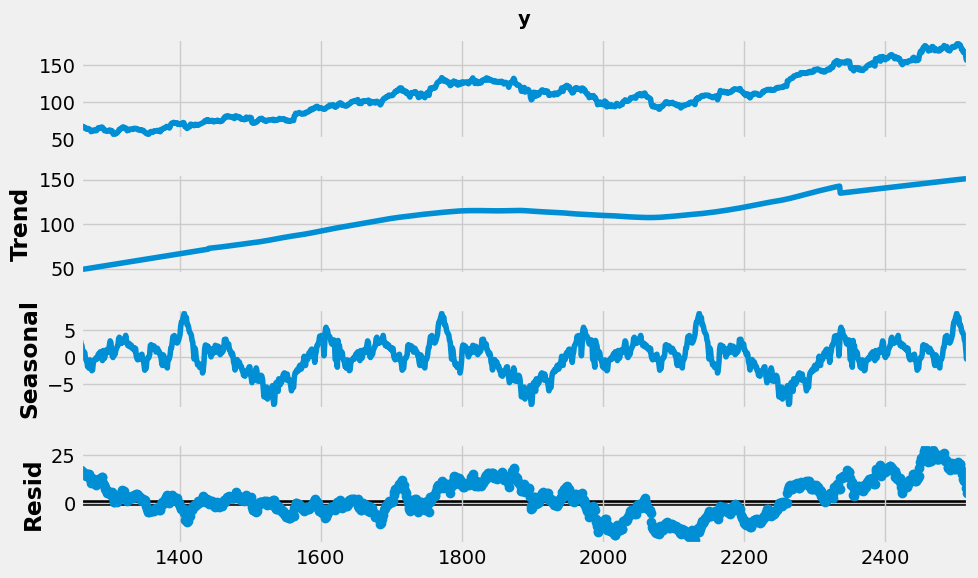

In [71]:
# let's find compoenets for aapl stock price
tr, se, re = decomposition(aplph_df, 365)

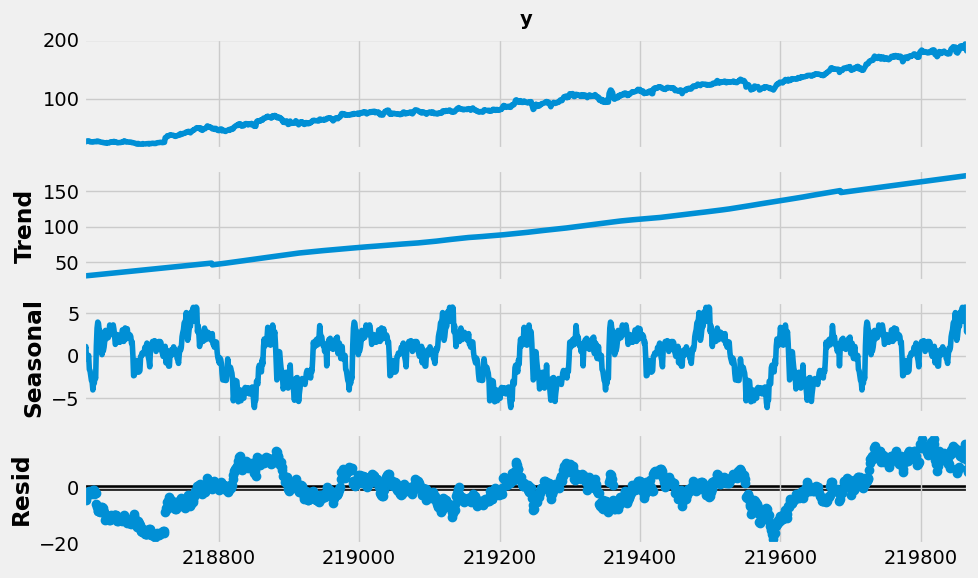

In [72]:
# let's find out components for fb stock price
ftr, fse, fre = decomposition(fbph_df, 365)

In [73]:
# function to retunr acf and pacf plots
def acf_pacf(df, lags):
    var = df['y']
    # plot the acf plot
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()
    
    # plot the pacf plots
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9,5))
    fig.tight_layout()
    plt.show()

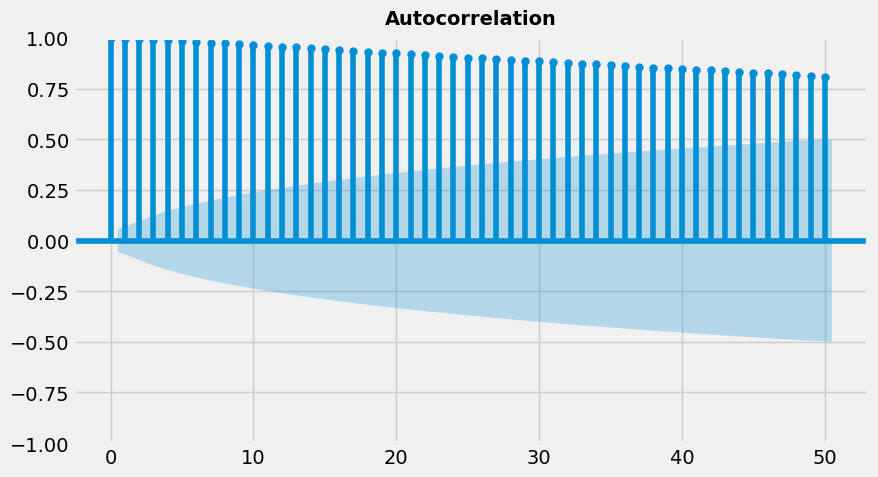

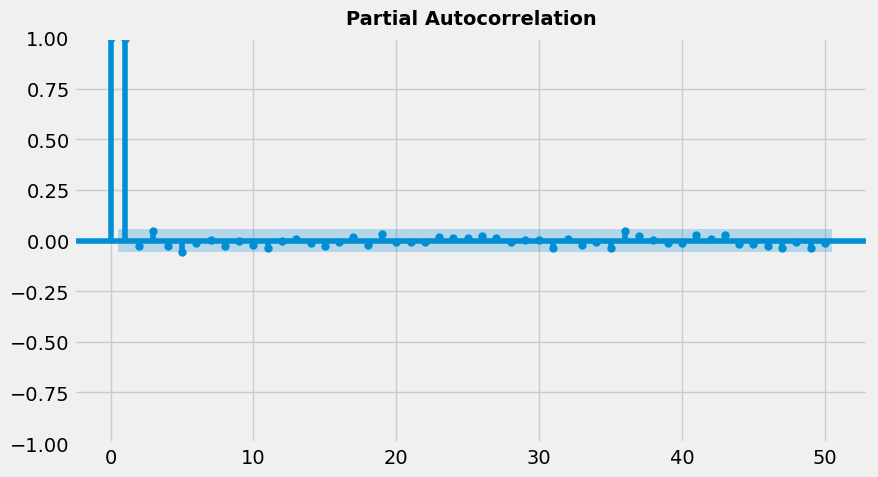

In [74]:
# acf and pacf of aapl stock 
acf_pacf(aplph_df, 50)

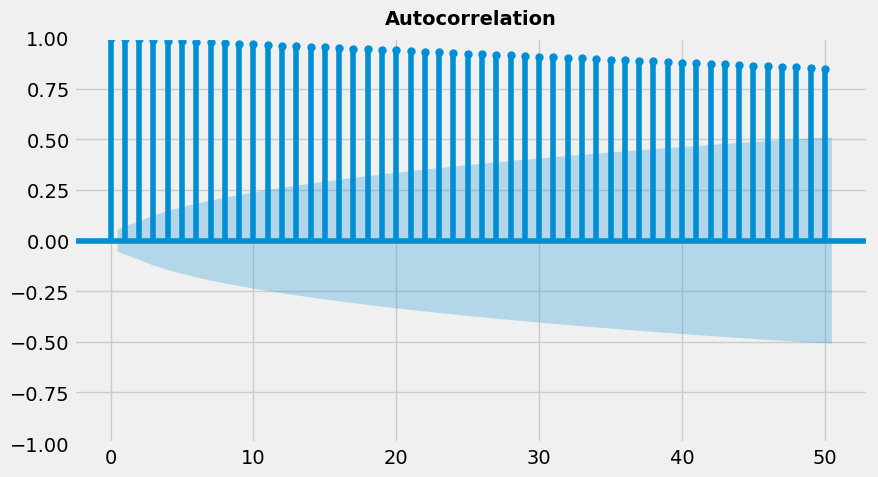

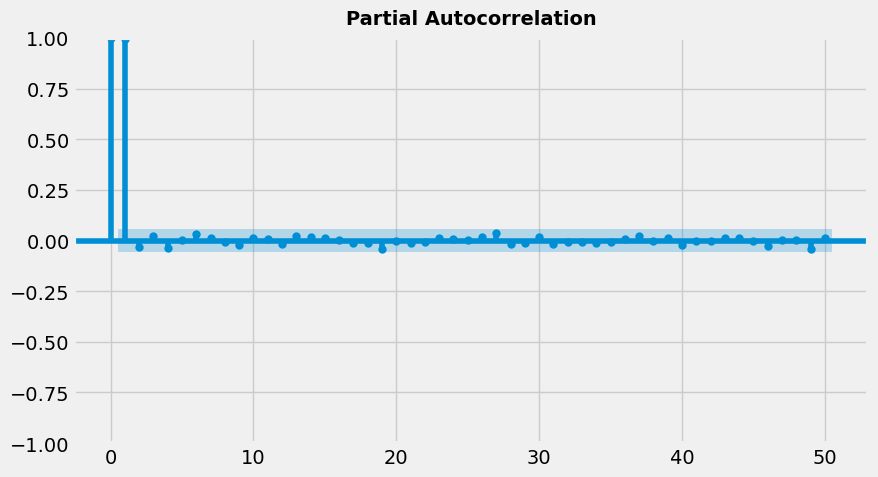

In [75]:
# acf and pacf plots of FB
acf_pacf(fbph_df, 50)

In [76]:
# funtion to return adfuller test results
def adfuller_test(df):
    adfuller_result = adfuller(df['y'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                           'Lags Used','Number of Observations Used'])
    print(adfuller_output)

In [77]:
print("adfuller test results for AAPLE")
adfuller_test(aplph_df)
print("----"*10)
print("adfuller test results for FB")
adfuller_test(fbph_df)

adfuller test results for AAPLE
Test statistic                   -0.665091
p-value                           0.855586
Lags Used                         0.000000
Number of Observations Used    1258.000000
dtype: float64
----------------------------------------
adfuller test results for FB
Test statistic                    0.177529
p-value                           0.970973
Lags Used                         8.000000
Number of Observations Used    1250.000000
dtype: float64


In [79]:
# funcrtion to split train and test time-series for modelling purpose
def arima_split(df, co_name):
    size = int(len(df)*0.95)
    train_df = (df['y'])[:size]
    test_df = (df['y'])[size:]
    
    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

apl_train, apl_test = arima_split(aplph_df, 'APPLE')
fb_train, fb_test = arima_split(fbph_df, 'FB')

data splits of company APPLE
Train Size: 1196, Test Size: 63
-------------------------------
data splits of company FB
Train Size: 1196, Test Size: 63
-------------------------------
